In [1]:
import dlib
from scipy.io import loadmat
from skimage import io
import argparse
import dlib
import glob
import cv2
from imutils import paths

In [28]:
filelist = glob.glob("/Users/Satish/Desktop/caltech-101/101_ObjectCategories/stop_sign/*")

In [29]:
filelist[0]

'/Users/Satish/Desktop/caltech-101/101_ObjectCategories/stop_sign/image_0001.jpg'

In [30]:
options = dlib.simple_object_detector_training_options()

In [35]:
images =[]
boxes =[]

for imagepath in filelist:
    imageID = imagepath.rsplit("/")[-1].rsplit("_")[1].replace(".jpg","")
    p = "/Users/Satish/Desktop/caltech-101/Annotations/stop_sign/annotation_{}.mat".format(x)
    annotations = loadmat(p)["box_coord"]
    bb = [dlib.rectangle(left=int(x), top=int(y), right=int(w), bottom=int(h)) for (y ,h , x, w) in annotations]
    boxes.append(bb)
    images.append(io.imread(imagepath))
    

In [37]:
print (len(images))
print (len(boxes))

64
64


In [38]:
print (images[0])
print (boxes[0])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[rectangle(99,42,237,179)]


In [39]:
# train the object detector 
detector = dlib.train_simple_object_detector(images, boxes, options)

In [42]:
# dump the classifier as file
detector.save("/Users/Satish/Desktop/caltech-101/model.svm")

In [69]:
# load the detector 
detector = dlib.simple_object_detector("/Users/Satish/Desktop/caltech-101/model.svm")

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# load the test image 
image = io.imread(imagepath)
boxes = detector(image)
print (boxes)

In [72]:
for b in boxes:
    (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    cv2.rectangle(image, (x,y), (w,h), (0, 255 , 0), 2)
    print (x,y,w,h)

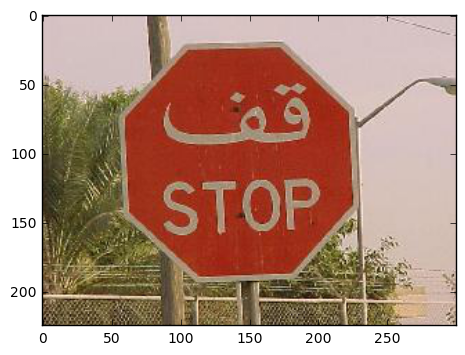

In [73]:
plt.imshow(image)
plt.show()

In [95]:
import json

In [96]:
with open('cars.json') as data_file:    
    data = json.load(data_file)
    
print (data)

{'offset': 5, 'use_flip': True, 'normalize': True, 'pyramid_scale': 1.5, 'image_distractions': '/Users/Satish/Desktop/caltech-101/SceneClass13', 'min_probability': 0.7, 'percent_gt_images': 0.5, 'window_dim': [96, 32], 'orientations': 9, 'cells_per_block': [2, 2], 'window_step': 4, 'overlap_thresh': 0.3, 'features_path': '/Users/Satish/Desktop/caltech-101/car_features.hdf5', 'num_distraction_per_image': 10, 'pixels_per_cell': [4, 4], 'num_distraction_images': 500, 'image_dataset': '/Users/Satish/Desktop/caltech-101/101_ObjectCategories/car_side', 'image_annotations': '/Users/Satish/Desktop/caltech-101/Annotations/car_side'}


In [97]:
from sklearn.feature_extraction.image import extract_patches_2d
from pyimagesearch.object_detection import helpers
from pyimagesearch.descriptors.hog import HOG 
from pyimagesearch.utils import dataset
from pyimagesearch.utils.conf import * 
from imutils import paths 
from scipy import io 
from scipy.io import loadmat
import numpy as np 
from tqdm import tqdm 
import argparse
import random 
import cv2 
import glob

In [98]:
conf = Conf("cars.json")

In [99]:
conf

In [100]:
hog = HOG(orientations=conf["orientations"], pixelsPerCell = tuple(conf["pixels_per_cell"]),\
          cellsPerBlock= tuple(conf["cells_per_block"]), normalize=conf["normalize"])

In [101]:
hog

In [102]:
data = []
labels = []

In [103]:
# grad the set of ground truth images and select a percentage of them for training
trnPaths = glob.glob(conf["image_dataset"]+"/*")
print (len(trnPaths))
trnPaths = random.sample(trnPaths, int(len(trnPaths)* conf["percent_gt_images"]))
print (len(trnPaths))
print ("describing training ROI")

123
61
describing training ROI


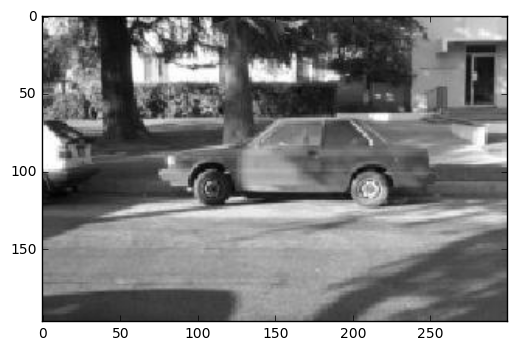

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(cv2.imread(trnPaths[23]))

In [105]:
# loop over the training paths
for (i, trnPath) in tqdm(enumerate(trnPaths)):
    image = cv2.imread(trnPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imageID = trnPath.rsplit("/")[-1].rsplit("_")[1].replace(".jpg","")
    p = conf["image_annotations"]+"/annotation_{}.mat".format(imageID)
    bb = loadmat(p)["box_coord"][0]
    roi = helpers.crop_ct101_bb(image, bb, padding=conf["offset"], dstSize=tuple(conf["window_dim"]))
    rois = (roi, cv2.flip(roi, 1)) if conf["use_flip"] else (roi,)

    for roi in rois:
        features = hog.describe(roi)
        data.append(features)
        labels.append(1)

In [106]:
print (len(data))
print (len(labels))

122
122


In [107]:
data[0].shape

(5796,)

In [108]:
# grad the set of ground truth images and select a percentage of them for training
dstPaths = glob.glob(conf["image_distractions"]+"/*")

In [109]:
dstPaths = [glob.glob(dstPaths[i]+"/*") for i in range(len(dstPaths))]

In [110]:
import itertools
merged = list(itertools.chain(*dstPaths))

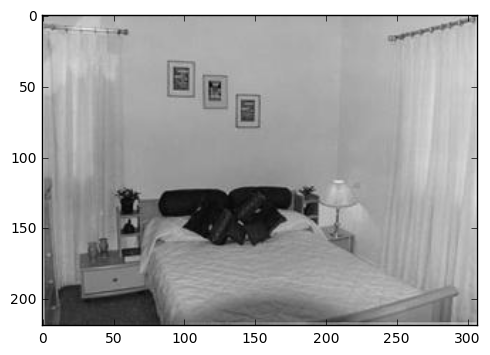

In [112]:
dstPaths = merged
plt.imshow(cv2.imread(random.choice(dstPaths)))

In [113]:
for i in tqdm(range(conf["num_distraction_images"])):
    image = cv2.imread(random.choice(dstPaths))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    patches = extract_patches_2d(image, tuple(conf["window_dim"]), max_patches=conf["num_distraction_per_image"])
    
    for patch in patches:
        features = hog.describe(patch)
        data.append(features)
        labels.append(-1)

In [114]:
len(data)

5122

In [115]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -